<a href="https://colab.research.google.com/github/rsourki/pinns-tutorial/blob/main/pinns_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks (PINNs) for Solving Differential Equations

---

Updated: 3 May 2025

Issues fixed:
- analytical solution provided for 2D steady-state heat equation has no heat source. The PINN is updated accordingly. The case with a heat source may be added later as a third subcase of this study.

---

## Author

**R. Sourki**

<a href="https://github.com/rsourki" target="_blank">GitHub</a>
|
<a href="https://www.linkedin.com/in/reza-sourki-89156260" target="_blank">LinkedIn</a>
|
<a href="https://sourki.com/physics-informed-neural-networks-intro/" target="_blank">PINNs Blog</a>


Feel free to reach out to me if you have any questions.

---

## Overview

This notebook demonstrates how to use PINNs to solve differential equations. Instead of relying on labeled datasets, PINNs embed the governing equations directly into the neural networks, enforcing physical constraints in the model.

You need to be familiar with simple feedforward neural network models as well as pytorch.

## Problems Covered

- First-order ODE example
- 1D Projectile Motion
- 2D Projectile Motion
- 1D Poisson Equation
- 1D Steady-State Heat Equation
- 2D Steady-State Heat Equation

No labled data is used in any of these examples.


_This notebook can be used for learning, experimentation, or as a base for more complex inverse or data-driven PDE problems. The material may be updated in the future._

# First-order ODE example


Here we solve the first-order ODE defined as below:

$$
\frac{du}{dt} = \cos(2\pi t), \quad t \in (0, 1)
$$

with the boundary conditions:

$$
u(0) = 1
$$


The analytical solution of this ODE is available as:

$$
u(t) = \frac{1}{2\pi} \sin(2\pi t) + 1
$$


Our goals is to use a neural network to approximate $$u(t)$$ by minimizing the following losses:

- **ODE loss**: $$\left( \frac{du}{dt} - \cos(2\pi t) \right)^2$$
- **Boundary condition loss**: $$(u(0) - 1)^2$$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the PINN architecture
class CPINN(nn.Module):
    def __init__(self):
        super(CPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),  # Input: t
            nn.Tanh(),
            nn.Linear(32, 1)   # Output: u(t)
        )

    def forward(self, t):
        return self.net(t)

In [ ]:
# Define the loss function combining the ODE and the initial condition
def ode_system(t, net):
    t = t.reshape(-1, 1)
    t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
    t_0 = torch.zeros((1, 1))  # Initial time t = 0
    one = torch.ones((1, 1))   # Expected initial value u(0) = 1

    # Forward pass
    u = net(t)

    # Compute du/dt using autograd
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Loss from the governing equation: du/dt - cos(2πt)
    ode_loss = u_t - torch.cos(2 * np.pi * t)

    # Loss from initial condition: u(0) - 1
    ic_loss = net(t_0) - one

    # Combined loss: mean squared error of both
    return torch.mean(torch.square(ode_loss) + torch.square(ic_loss))


In [ ]:
# Generate training points in t ∈ [0, 2]
train_t = (torch.rand(30) * 2).reshape(-1, 1)
train_loss_record = []

In [ ]:
# Instantiate model and optimizer
model = CPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for itr in range(6000):
    optimizer.zero_grad()
    train_loss = ode_system(train_t, model)
    train_loss_record.append(train_loss.detach().numpy())
    train_loss.backward()
    optimizer.step()

    if itr % 1000 == 0:
        print(f"Iteration {itr}: Loss = {train_loss.item()}")


<ipython-input-4-216d83b71f3e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, requires_grad=True)


Iteration 0: Loss = 1.1362895965576172
Iteration 1000: Loss = 0.48039838671684265
Iteration 2000: Loss = 0.09174958616495132
Iteration 3000: Loss = 0.005904419347643852
Iteration 4000: Loss = 0.00034494942519813776
Iteration 5000: Loss = 0.00011182136222487316


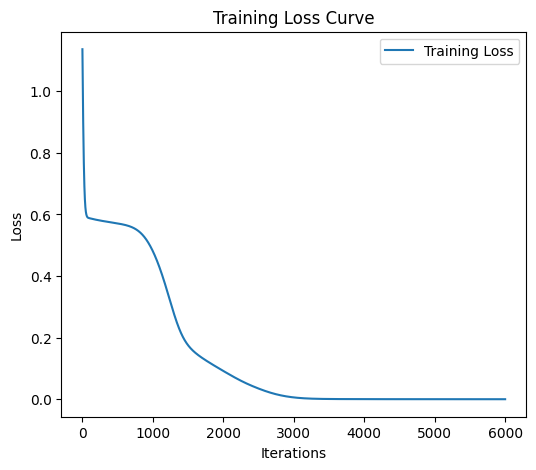

In [ ]:
# Plot training loss
plt.figure(figsize=(6, 5))
plt.plot(train_loss_record, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Evaluation on test data
test_t = torch.Tensor(np.linspace(0, 2, 100).reshape(-1, 1))

# Ground truth: u(t) = (1 / 2π) * sin(2πt) + 1
true_u = np.sin(2 * np.pi * test_t) / (2 * np.pi) + 1

# Model prediction
with torch.no_grad():
    pred_u = model(test_t).numpy()

<ipython-input-10-4d703ca9a201>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_u = np.sin(2 * np.pi * test_t) / (2 * np.pi) + 1


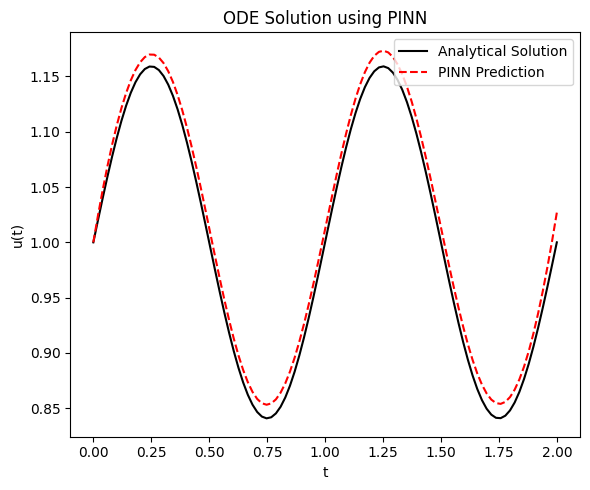

In [ ]:
# Plot predictions vs true solution
plt.figure(figsize=(6, 5))
plt.plot(test_t, true_u, '-k', label='Analytical Solution')
plt.plot(test_t.numpy(), pred_u, '--r', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('ODE Solution using PINN')
plt.legend()
plt.tight_layout()
plt.show()

# 1D Projectile Motion

We model the **1D projectile motion of a particle** under constant acceleration using a PINN.


Here we assume:
- Initial position: $$ x_0 = 10 $$
- Initial velocity: $$ v_0 = 5 $$
- Constant acceleration: $$ a = 9 $$

The analytical solution of position over time is:

$$
x(t) = \frac{1}{2} a t^2 + v_0 t + x_0
$$

The corresponding second-order ODE is:

$$
\frac{d^2 x}{dt^2} = a
$$



We want to approximate $u(t)$ by minimizing the following loss function:

- **ODE residual**:
  $$
  \left( \frac{d^2 x}{dt^2} - a \right)^2
  $$
- **Boundary conditions**:
  $$
  (x(0) - x_0)^2
  $$
  $$
  \left( \frac{dx}{dt}(0) - v_0 \right)^2
  $$


Here, the loss is a weighted sum of:
- ODE loss
- Boundary condition losses (displacement and velocity)

Our neural network here learns the projectile motion without any labled data.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class CPINN(nn.Module):
  def __init__(self):
    super(CPINN, self).__init__()
    self.HiddenLayer_1 = nn.Linear(1, 32)
    self.FinalLayer = nn.Linear(32, 1)
    self.ActivateTanh = nn.Tanh()
    nn.init.xavier_uniform_(self.HiddenLayer_1.weight)

  def forward(self, t):
    x = self.ActivateTanh(self.HiddenLayer_1(t))
    return self.FinalLayer(x)

In [ ]:
# Define the loss function with physics and initial conditions
def ODE_Loss(t, x0, v0, a, model):
  t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
  t0 = torch.tensor([[0.0]], requires_grad=True)

  u = model(t)
  u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]

  # Enforce conditions at t=0
  idx0 = (t == 0).nonzero(as_tuple=True)[0]
  u0 = u[idx0]
  u_t0 = u_t[idx0]  # Velocity (derivative of disp u at t0)

  # Physics and initial condition losses
  a_loss = torch.mean((u_tt - a)**2)
  x0_loss = torch.mean((u0 - x0)**2)
  v0_loss = torch.mean((u_t0 - v0)**2)

  normalized = 10*x0_loss + 100*v0_loss + a_loss

  return torch.sum(normalized), a_loss, x0_loss, v0_loss

In [ ]:
model = CPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

a = torch.tensor([9.0])
v0 = torch.tensor([5.0])
x0 = torch.tensor([10.0])

t_train = torch.linspace(0, 10, 50).reshape(-1, 1)

losses, a_losses, x0_losses, v0_losses = [], [], [], []
iteration = 0
converged = False

while not converged:
  iteration += 1
  optimizer.zero_grad()

  total_loss, a_loss, x0_loss, v0_loss = ODE_Loss(t_train, x0, v0, a, model)
  total_loss.backward()
  optimizer.step()

  if iteration % 5000 == 0:
    print(f"Epoch {iteration}, Loss: {total_loss.item():.6f}")
    losses.append(total_loss.item())
    a_losses.append(a_loss.item())
    x0_losses.append(x0_loss.item())
    v0_losses.append(v0_loss.item())

  if a_loss < 1e-3 and x0_loss < 1e-3 and v0_loss < 1e-3:
    converged = True

<ipython-input-46-ef9ed5dc7916>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, requires_grad=True)


Epoch 5000, Loss: 90.009842
Epoch 10000, Loss: 30.400564
Epoch 15000, Loss: 2.663731
Epoch 20000, Loss: 0.435236
Epoch 25000, Loss: 0.306775
Epoch 30000, Loss: 0.232699
Epoch 35000, Loss: 0.206931
Epoch 40000, Loss: 0.156264
Epoch 45000, Loss: 0.134627
Epoch 50000, Loss: 0.118342
Epoch 55000, Loss: 0.105787
Epoch 60000, Loss: 0.095257
Epoch 65000, Loss: 0.085041
Epoch 70000, Loss: 0.066079
Epoch 75000, Loss: 0.047425
Epoch 80000, Loss: 0.040254
Epoch 85000, Loss: 0.026155
Epoch 90000, Loss: 0.018506
Epoch 95000, Loss: 0.013447
Epoch 100000, Loss: 0.010277
Epoch 105000, Loss: 0.008407
Epoch 110000, Loss: 0.006962
Epoch 115000, Loss: 0.100588
Epoch 120000, Loss: 0.004798
Epoch 125000, Loss: 0.004087
Epoch 130000, Loss: 0.009998
Epoch 135000, Loss: 0.011231
Epoch 140000, Loss: 0.048793
Epoch 145000, Loss: 0.004450
Epoch 150000, Loss: 0.001843
Epoch 155000, Loss: 0.001576
Epoch 160000, Loss: 0.001409
Epoch 165000, Loss: 0.006305
Epoch 170000, Loss: 0.001164
Epoch 175000, Loss: 0.001071


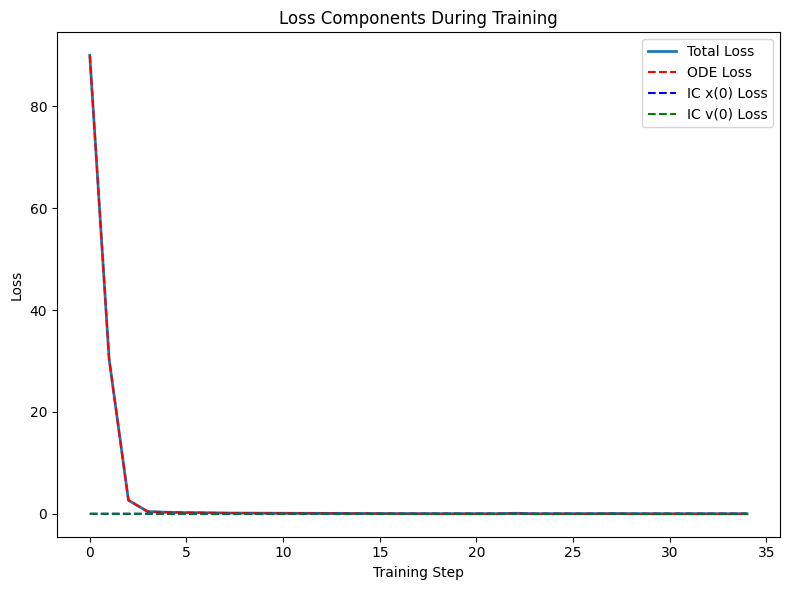

In [ ]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Total Loss', linewidth=2)
plt.plot(a_losses, '--r', label='ODE Loss')
plt.plot(x0_losses, '--b', label='IC x(0) Loss')
plt.plot(v0_losses, '--g', label='IC v(0) Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss Components During Training')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Check if collected gradients are correct
test_t = torch.tensor(np.linspace(0, 10, 10).reshape(-1, 1), dtype=torch.float32, requires_grad=True)

# Prediction
u = model(test_t)
u_t = torch.autograd.grad(u.sum(), test_t, create_graph=True)[0]  # First derivative
u_tt = torch.autograd.grad(u_t.sum(), test_t)[0]  # Second derivative

# Print the predicted derivatives and compare with the true derivatives
print("\n Prediction derivative (u_t): \n", u_t[:], "\n True derivative (a * t + v_0): \n", a * test_t[:] + v0)
print("\n\n")
print("\n Prediction 2nd derivative (u_tt): \n", u_tt[:], "\n True 2nd derivative (a): \n", a[:])



 Prediction derivative (u_t): 
 tensor([[ 5.0000],
        [14.9852],
        [24.9675],
        [34.9731],
        [44.9792],
        [54.9721],
        [64.9679],
        [74.9697],
        [84.9807],
        [94.9999]], grad_fn=<SliceBackward0>) 
 True derivative (a * t + v_0): 
 tensor([[ 5.],
        [15.],
        [25.],
        [35.],
        [45.],
        [55.],
        [65.],
        [75.],
        [85.],
        [95.]], grad_fn=<AddBackward0>)




 Prediction 2nd derivative (u_tt): 
 tensor([[9.0000],
        [8.9955],
        [9.0209],
        [8.9669],
        [9.0061],
        [9.0331],
        [9.0376],
        [9.0534],
        [9.0128],
        [8.9991]]) 
 True 2nd derivative (a): 
 tensor([9.])


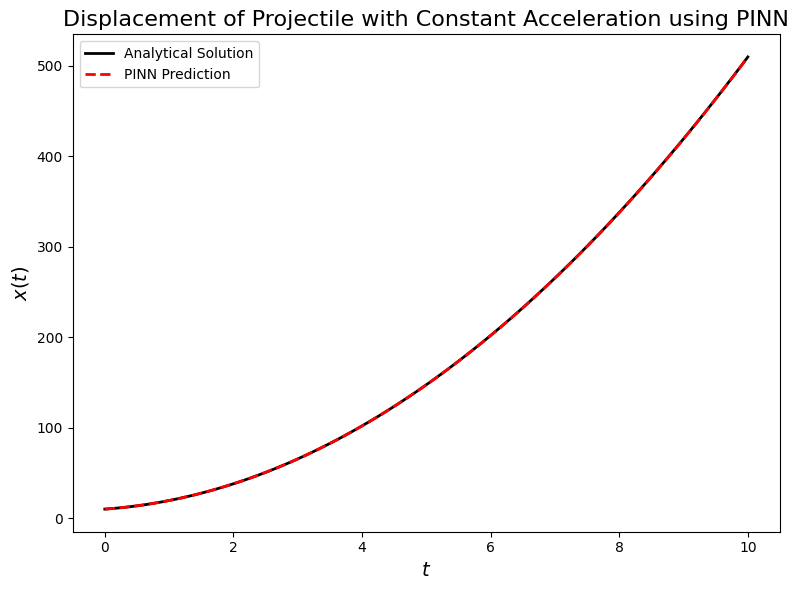

In [ ]:
# Evaluate and plot predictions
t_test = torch.linspace(0, 10, 100).reshape(-1, 1)
true_x = 0.5 * a * t_test**2 + v0 * t_test + x0

with torch.no_grad():
  pred_x = model(t_test)

plt.figure(figsize=(8, 6))
plt.plot(t_test, true_x, '-k', label='Analytical Solution', linewidth=2)
plt.plot(t_test, pred_x, '--r', label='PINN Prediction', linewidth=2)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$x(t)$', fontsize=14)
plt.title('Displacement of Projectile with Constant Acceleration using PINN', fontsize=16)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 2D Projectile Motion


We consider the special case of 2D projectile motion with constant acceleration in the vertical direction due to gravity:
  $$ a_y = -g $$
  $$ a_x = 0 $$

### Position Equations:

$$
y(t) = -\frac{1}{2}gt^2 + v_{y0}t + y_0
$$
$$
x(t) = v_{x0}t + x_0
$$


### Velocity Equations:

$$
v_y(t) = -gt + v_{y0}
$$
$$
v_x(t) = v_{x0}
$$


### Governing Differential Equation:

$$
\frac{d^2 y}{d t^2} = -g
\quad \text{and} \quad
\frac{d^2 x}{d t^2} = 0
$$


### Boundary Conditions:

$$
y(t_0) = y_0, \quad x(t_0) = x_0
$$
$$
v_y(t_0) = v_{y0}, \quad v_x(t_0) = v_{x0}
$$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Define the Physics-Informed Neural Network
class CPINN(nn.Module):
  """
  PINN for 2D projectile motion. Takes time as input and outputs X and Y positions.
  """
  def __init__(self):
    super(CPINN, self).__init__()
    self.hidden_size = 32
    self.hidden_1 = nn.Linear(1, self.hidden_size)
    self.output_layer = nn.Linear(self.hidden_size, 2)
    self.activation = nn.Tanh()

    # Initialize weights
    nn.init.xavier_uniform_(self.hidden_1.weight)

  def forward(self, t):
    x = self.activation(self.hidden_1(t))
    return self.output_layer(x)


In [ ]:

# Loss function based on ODE residuals and initial conditions
def ODE_2D_Loss(t, pos0, vel0, accel, model):
  assert torch.is_tensor(t) is True, "Input feature (time) must be tensor."
  assert torch.is_tensor(pos0) is True, "Input pos0 must be tensor."
  assert torch.is_tensor(vel0) is True, "Input vel0 must be tensor."
  t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
  t0 = torch.tensor([0.0], requires_grad=True)

  # Model prediction
  u = model(t)
  x, y = u[:, 0], u[:, 1]

  # Compute derivatives
  x_t = torch.autograd.grad(x, t, torch.ones_like(x), retain_graph=True, create_graph=True)[0]
  y_t = torch.autograd.grad(y, t, torch.ones_like(y), retain_graph=True, create_graph=True)[0]
  x_tt = torch.autograd.grad(x_t, t, torch.ones_like(x_t), retain_graph=True, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t, t, torch.ones_like(y_t), retain_graph=True, create_graph=True)[0]

  # Get values at t = 0
  t0_idx = (t == t0).nonzero(as_tuple=True)[0]
  x0_pred, y0_pred = x[t0_idx], y[t0_idx]
  vx0_pred, vy0_pred = x_t[t0_idx], y_t[t0_idx]

  # Physics-informed loss
  loss = torch.mean( 0.8 * (torch.square(x_tt - accel[0]) + torch.square(y_tt - accel[1]))
  + 800 * (torch.square(vx0_pred - vel0[0]) + torch.square(vy0_pred - vel0[1]) )
  + 1 * (torch.square(x0_pred - pos0[0]) + torch.square(y0_pred - pos0[1])) )


  return loss


In [ ]:
# Hyperparameters and initial conditions
learning_rate = 1e-3
epochs = 100000
loss_history = []

accel = torch.tensor([0.0, 9.0], dtype=torch.float32)
pos0 = torch.tensor([0.0, 0.0], dtype=torch.float32)
vel0 = torch.tensor([2.0, 2.0], dtype=torch.float32)

# Training input (time)
t_start, t_end, num_points = 0, 10, 50
train_t = torch.tensor(np.linspace(t_start, t_end, num_points).reshape(-1, 1), dtype=torch.float32, requires_grad=True)

# Ground truth for reference (not used in training)
train_x = 0.5 * accel[0] * train_t**2 + vel0[0] * train_t + pos0[0]
train_y = -0.5 * accel[1] * train_t**2 + vel0[1] * train_t + pos0[1]

# Model and optimizer
model = CPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
  optimizer.zero_grad()
  loss = ODE_2D_Loss(train_t, pos0, vel0, accel, model)
  if epoch % 1000 == 0:
    loss_history.append(loss.item())

  # Backward pass
  loss.backward()
  optimizer.step()

  if epoch % 5000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")



<ipython-input-76-c25ae7914165>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, requires_grad=True)


Epoch 0, Loss: 5915.84375
Epoch 5000, Loss: 67.64132690429688
Epoch 10000, Loss: 63.610347747802734
Epoch 15000, Loss: 44.41095733642578
Epoch 20000, Loss: 22.232145309448242
Epoch 25000, Loss: 8.121020317077637
Epoch 30000, Loss: 1.4778549671173096
Epoch 35000, Loss: 0.033656757324934006
Epoch 40000, Loss: 0.005544869229197502
Epoch 45000, Loss: 0.005862116813659668
Epoch 50000, Loss: 0.010299296118319035
Epoch 55000, Loss: 0.0022824641782790422
Epoch 60000, Loss: 0.0020611146464943886
Epoch 65000, Loss: 0.0024260173086076975
Epoch 70000, Loss: 0.001832867506891489
Epoch 75000, Loss: 0.001631230115890503
Epoch 80000, Loss: 0.0015419595874845982
Epoch 85000, Loss: 0.0016451127594336867
Epoch 90000, Loss: 0.0014158433768898249
Epoch 95000, Loss: 0.009717517532408237


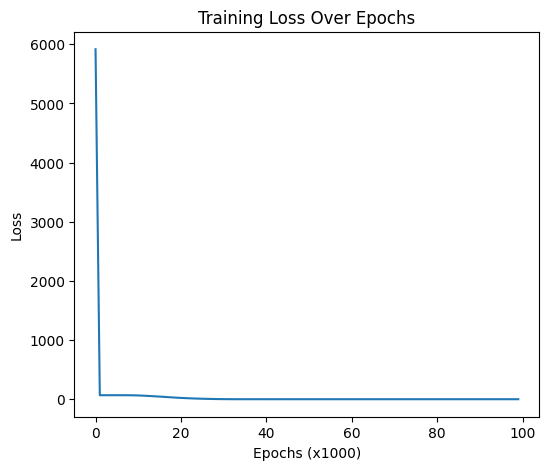

In [ ]:
# Plot training loss
plt.figure(figsize=(6, 5))
plt.plot(loss_history)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs (x1000)")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Check if collected gradients are correct
test_t = torch.tensor(np.linspace(0, 10, 10).reshape(-1, 1), dtype=torch.float32, requires_grad=True)

# Prediction
u = model(test_t)
x, y = u[:, 0], u[:, 1]

x_t = torch.autograd.grad(x, test_t, grad_outputs = torch.ones_like(x), retain_graph = True, create_graph = True)[0]
x_tt = torch.autograd.grad(x_t, test_t, grad_outputs = torch.ones_like(x_t), retain_graph = True, create_graph = True)[0]

y_t = torch.autograd.grad(y, test_t, grad_outputs = torch.ones_like(y), retain_graph = True, create_graph = True)[0]
y_tt = torch.autograd.grad(y_t, test_t, grad_outputs = torch.ones_like(y_t), retain_graph = True, create_graph = True)[0]

print("\n Prediction 2nd derivative {x_dtdt} \n True 2nd derivative {true_t}".format(x_dtdt = x_tt[:], true_t = accel[0]))

print("\n Prediction derivative {y_dt} \n True derivative {true_t}".format(y_dt = y_t[:], true_t = accel[1] * test_t[:]))
print("\n\n")
print("\n Prediction 2nd derivative {y_dtdt} \n True 2nd derivative {true_t}".format(y_dtdt = y_tt[:], true_t = accel[1]))


 Prediction 2nd derivative tensor([[-9.0025e-03],
        [ 2.1694e-02],
        [ 8.6510e-04],
        [-5.7077e-04],
        [ 6.1145e-04],
        [-9.2402e-05],
        [ 3.2364e-04],
        [ 5.9277e-04],
        [ 3.4294e-04],
        [ 1.0772e-04]], grad_fn=<SliceBackward0>) 
 True 2nd derivative 0.0

 Prediction derivative tensor([[ 1.9992],
        [12.0294],
        [22.0229],
        [32.0205],
        [42.0203],
        [52.0204],
        [62.0181],
        [72.0210],
        [82.0191],
        [92.0642]], grad_fn=<SliceBackward0>) 
 True derivative tensor([[ 0.],
        [10.],
        [20.],
        [30.],
        [40.],
        [50.],
        [60.],
        [70.],
        [80.],
        [90.]], grad_fn=<MulBackward0>)




 Prediction 2nd derivative tensor([[8.9705],
        [8.9673],
        [8.9437],
        [8.9557],
        [8.9657],
        [8.9741],
        [9.0054],
        [9.0177],
        [9.0118],
        [9.0025]], grad_fn=<SliceBackward0>) 
 True 2nd deriva

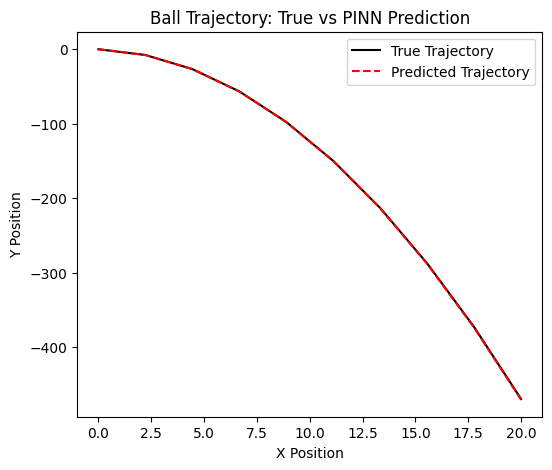

In [ ]:
# Compare with true values
with torch.no_grad():
  true_x = 0.5 * accel[0] * test_t**2 + vel0[0] * test_t + pos0[0]
  true_y = 0.5 * accel[1] * test_t**2 + vel0[1] * test_t + pos0[1]
  pred_xy = model(test_t).numpy()

plt.figure(figsize=(6, 5))
plt.plot(true_x, -true_y, '-k', label="True Trajectory")
plt.plot(pred_xy[:, 0], -pred_xy[:, 1], '--r', label="Predicted Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Ball Trajectory: True vs PINN Prediction")
plt.show()


# 1D Poisson Equation


Here, we aim to solve the 1D Poisson equation. The governing equation is expressed as:

$$
\frac{d^2 u(x)}{dx^2} = f(x), \quad x \in (0, 1)
$$

Dirichlet boundary conditions are:

$$
u(0) = 0, \quad u(1) = 0
$$

By choosing a source function as:

$$
f(x) = \pi^2 \sin(\pi x)
$$

the following analytical solution can be found:

$$
u(x) = \sin(\pi x)
$$


The PINN is trained by minimizing a total loss consisting of:

- **PDE loss**:
  $$
  \left( \frac{d^2 u}{dx^2} + f(x) \right)^2
  $$

- **Boundary condition loss**:
  $$
  (u(0) - 0)^2 + (u(1) - 0)^2
  $$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the neural network model
class CPINN_Poisson1D(nn.Module):
  def __init__(self):
    super(CPINN_Poisson1D, self).__init__()
    self.hidden = nn.Sequential(
        nn.Linear(1, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    return self.hidden(x)

# Define the source function f(x) = pi^2 * sin(pi * x)
def source_function(x):
  return (np.pi ** 2) * torch.sin(np.pi * x)

In [ ]:
# Loss function combining PDE and boundary conditions
def poisson_loss(model, x_interior, x_boundary, u_boundary):
  x_interior.requires_grad = True
  u = model(x_interior)

  # First and second derivatives
  u_x = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

  f = source_function(x_interior)

  # PDE loss
  loss_pde = torch.mean((u_xx + f) ** 2)

  # Boundary loss
  u_b_pred = model(x_boundary)
  loss_bc = torch.mean((u_b_pred - u_boundary) ** 2)

  return loss_pde + loss_bc

In [ ]:
# Generate training data
x_interior = torch.linspace(0, 1, 100).reshape(-1, 1)[1:-1]  # exclude boundaries
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32)
u_boundary = torch.tensor([[0.0], [0.0]], dtype=torch.float32)

# Instantiate model and optimizer
model = CPINN_Poisson1D()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 5000
loss_record = []

for epoch in range(epochs):
  optimizer.zero_grad()
  loss = poisson_loss(model, x_interior, x_boundary, u_boundary)
  loss.backward()
  optimizer.step()

  if epoch % 500 == 0:
    loss_record.append(loss.item())
    print(f"Epoch {epoch} | Loss: {loss.item()}")


Epoch 0 | Loss: 47.221160888671875
Epoch 500 | Loss: 0.002740552881732583
Epoch 1000 | Loss: 0.00029081181855872273
Epoch 1500 | Loss: 0.00021869527699891478
Epoch 2000 | Loss: 0.00015832326607778668
Epoch 2500 | Loss: 0.00010826761717908084
Epoch 3000 | Loss: 7.064543751766905e-05
Epoch 3500 | Loss: 4.52749700343702e-05
Epoch 4000 | Loss: 2.9958082450320944e-05
Epoch 4500 | Loss: 3.3187730878125876e-05


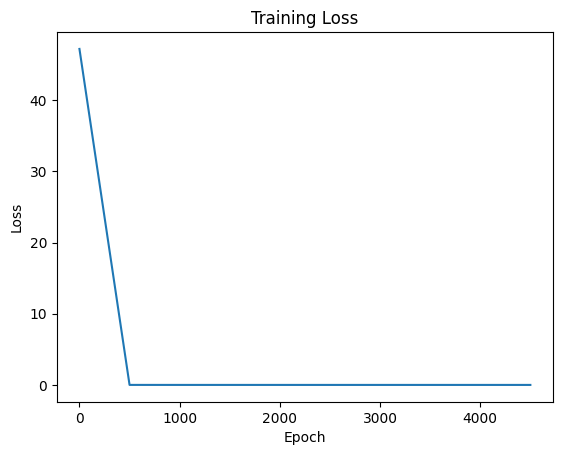

In [ ]:
# Plot the loss
plt.plot(np.arange(0, epochs, 500), loss_record)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

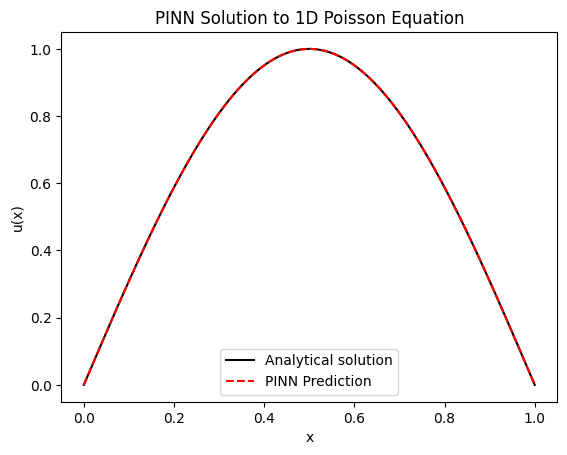

In [ ]:
# Evaluate model
x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
with torch.no_grad():
  u_pred = model(x_test).numpy()

u_true = np.sin(np.pi * x_test.numpy())

# Plot solution
plt.plot(x_test.numpy(), u_true, label="Analytical Solution", color="black")
plt.plot(x_test.numpy(), u_pred, '--r', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("PINN Solution to 1D Poisson Equation")
plt.show()


# 1D Steady-State Heat Equation

Here we aim to solve the 1D steady-state heat conduction equation. The governing equation is:

$$
\frac{d^2 T(x)}{dx^2} = -\frac{q}{k}, \quad x \in (0, L)
$$

where $T(x)$ is the temperature distribution, $q$ is the uniform internal heat generation rate, $k$ is the thermal conductivity (assumed constant), and $L$ is the length of the domain.

We assume:
$ q = 1 $,
$ k = 1 $,
$ L = 1 $.

which simplifies the equation to:

$$
\frac{d^2 T(x)}{dx^2} = -1
$$

with Dirichlet boundary conditions:

$$
T(0) = 0, \quad T(1) = 0
$$

The analytical solution can be found as:

$$
T(x) = \frac{1}{2}x(1 - x)
$$


The PINN minimizes the total loss composed of:

- **PDE loss**:
  $$
  \left( \frac{d^2 T}{dx^2} + 1 \right)^2
  $$

- **Boundary condition loss**:
  $$
  (T(0) - 0)^2 + (T(1) - 0)^2
  $$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CHeatPINN(nn.Module):
  def __init__(self):
    super(CHeatPINN, self).__init__()
    self.hidden = 32
    self.net = nn.Sequential(
        nn.Linear(1, self.hidden),
        nn.Tanh(),
        nn.Linear(self.hidden, self.hidden),
        nn.Tanh(),
        nn.Linear(self.hidden, 1)
    )
    for layer in self.net:
      if isinstance(layer, nn.Linear):
          nn.init.xavier_uniform_(layer.weight)

  def forward(self, x):
    return self.net(x)

In [3]:
# Define the PDE loss
def HeatLoss(x, model):
  x.requires_grad = True
  T = model(x)

  # First derivative
  T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
  # Second derivative
  T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]

  # PDE loss: d²T/dx² + 1 = 0  ⇒  residual = T_xx + 1
  pde_loss = torch.mean((T_xx + 1)**2)

  # Boundary condition losses
  T_0 = model(torch.tensor([[0.0]]))
  T_1 = model(torch.tensor([[1.0]]))
  bc_loss = (T_0**2 + T_1**2).mean()

  return pde_loss + 100 * bc_loss

In [4]:
# Training
model = CHeatPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10000

# Training domain
x_train = torch.tensor(np.linspace(0, 1, 100).reshape(-1, 1), dtype=torch.float32)

losses = []

for epoch in range(epochs):
  optimizer.zero_grad()
  loss = HeatLoss(x_train, model)
  loss.backward()
  optimizer.step()

  if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch 0, Loss: 1.5800120830535889
Epoch 1000, Loss: 0.0002767673577181995
Epoch 2000, Loss: 0.0001089924480766058
Epoch 3000, Loss: 7.246748282341287e-05
Epoch 4000, Loss: 5.5042022722773254e-05
Epoch 5000, Loss: 2.930799382738769e-05
Epoch 6000, Loss: 1.767719368217513e-05
Epoch 7000, Loss: 0.01845887303352356
Epoch 8000, Loss: 0.0024930438958108425
Epoch 9000, Loss: 5.276498086459469e-06


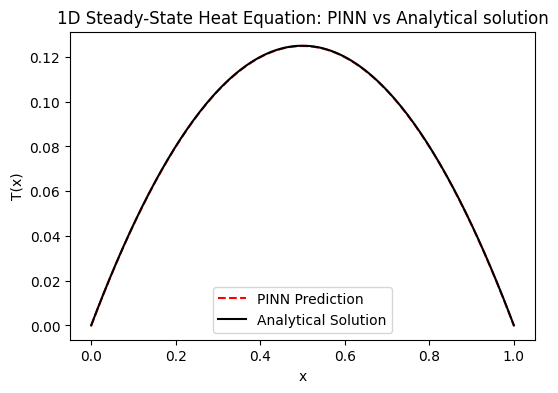

In [5]:
# Plotting the solution
x_plot = torch.tensor(np.linspace(0, 1, 200).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
  T_pred = model(x_plot).numpy()

# Analytical solution: T(x) = 0.5 * x * (1 - x)
T_true = 0.5 * x_plot.numpy() * (1 - x_plot.numpy())

plt.figure(figsize=(6, 4))
plt.plot(x_plot, T_pred, 'r--', label='PINN Prediction')
plt.plot(x_plot, T_true, 'k-', label='Analytical Solution')
plt.xlabel('x')
plt.ylabel('T(x)')
plt.legend()
plt.title('1D Steady-State Heat Equation: PINN vs Analytical solution')
plt.show()


# 2D Steady-State Heat Equation

We solve the 2D steady-state heat conduction (Poisson) equation using PINN. The governing equation is:

$$
\frac{\partial^2 T(x, y)}{\partial x^2} + \frac{\partial^2 T(x, y)}{\partial y^2} = -f(x, y), \quad (x, y) \in (0, 1) \times (0, 1)
$$

Using the following source term:

$$
f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)
$$

## subcase one

### Boundary Conditions

The Dirichlet boundary conditions on all sides of the square domain can be written as:

$$
T(x, y) = 0, \quad \text{for } x = 0, x = 1, y = 0, y = 1
$$

### Losses

The neural network approximates the temperature field $$T(x, y)$$ by minimizing the PDe and BC losses:

- **PDE Loss**:

  $$
  \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} + f(x, y) \right)^2
  $$

- **Boundary Condition Loss**:

  $$
  T(x, y)^2 \quad \text{on all boundaries}
  $$


The exact analytical solution will be:

$$
T(x, y) = \sin(\pi x) \sin(\pi y)
$$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# PINN class
class CHeat2D_PINN(nn.Module):
  def __init__(self):
    super(CHeat2D_PINN, self).__init__()
    self.hidden_dim = 64
    self.net = nn.Sequential(
        nn.Linear(2, self.hidden_dim),
        nn.Tanh(),
        nn.Linear(self.hidden_dim, self.hidden_dim),
        nn.Tanh(),
        nn.Linear(self.hidden_dim, 1)
    )
    for layer in self.net:
      if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

  def forward(self, x):
    return self.net(x)

# Source term: f(x, y)
def source_term(xy):
  x, y = xy[:, 0:1], xy[:, 1:2]
  return 2 * np.pi**2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)

In [ ]:
# PDE loss
def Heat2D_Loss(xy, model):
  xy.requires_grad = True
  T = model(xy)

  grads = torch.autograd.grad(T, xy, grad_outputs=torch.ones_like(T), create_graph=True)[0]
  T_x = grads[:, 0:1]
  T_y = grads[:, 1:2]

  T_xx = torch.autograd.grad(T_x, xy, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0:1]
  T_yy = torch.autograd.grad(T_y, xy, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1:2]

  f = source_term(xy)

  pde_loss = torch.mean((T_xx + T_yy + f) ** 2)

  # Enforce T=0 on the boundary
  bc_x = torch.linspace(0, 1, 50)
  bc_y = torch.linspace(0, 1, 50)
  bc = []

  for i in bc_x:
    bc.append(torch.tensor([[i, 0.0], [i, 1.0]]))
  for j in bc_y:
    bc.append(torch.tensor([[0.0, j], [1.0, j]]))

  bc = torch.cat(bc, dim=0)
  bc_T = model(bc)
  bc_loss = torch.mean(bc_T ** 2)

  return pde_loss + 100 * bc_loss


In [ ]:
# Train the model
model = CHeat2D_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training domain: sample interior points in (0,1)x(0,1)
xy_train = torch.tensor(np.random.rand(5000, 2), dtype=torch.float32)

losses = []
epochs = 10000
for epoch in range(epochs):
  optimizer.zero_grad()
  loss = Heat2D_Loss(xy_train, model)
  loss.backward()
  optimizer.step()

  if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch 0, Loss: 110.58258056640625
Epoch 1000, Loss: 0.15973803400993347
Epoch 2000, Loss: 0.012648094445466995
Epoch 3000, Loss: 0.0053052823059260845
Epoch 4000, Loss: 0.002928617410361767
Epoch 5000, Loss: 0.0018807174637913704
Epoch 6000, Loss: 0.0012289005098864436
Epoch 7000, Loss: 0.023675478994846344
Epoch 8000, Loss: 0.012546566314995289
Epoch 9000, Loss: 0.0040682400576770306


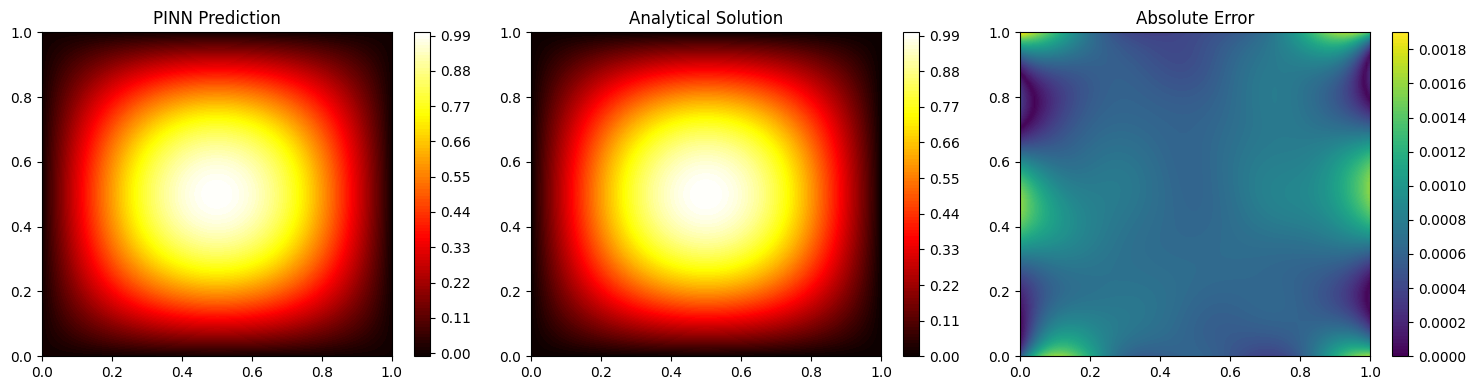

In [ ]:
# Plot results
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy_test = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

with torch.no_grad():
  T_pred = model(xy_test).numpy().reshape(100, 100)

T_true = np.sin(np.pi * X) * np.sin(np.pi * Y)
error = np.abs(T_pred - T_true)

plt.figure(figsize=(15, 4))

# PINN Prediction
plt.subplot(1, 3, 1)
plt.contourf(X, Y, T_pred, levels=100, cmap='hot')
plt.colorbar()
plt.title('PINN Prediction')

# Analytical Solution
plt.subplot(1, 3, 2)
plt.contourf(X, Y, T_true, levels=100, cmap='hot')
plt.colorbar()
plt.title('Analytical Solution')

# Absolute Error
plt.subplot(1, 3, 3)
plt.contourf(X, Y, error, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()


## subcase two
Let's change the boundary condition.
We solve the 2D steady-state heat equation:

$$
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0, \quad (x, y) \in (0,1) \times (0,1)
$$

with Dirichlet boundary conditions:
- \( T(x=0, y) = 1 \) (left side)
- \( T = 0 \) on all other boundaries.

The analytical solution is expressed as a Fourier sine series:

$$
T(x, y) = \sum_{n=1,3,5,\dots}^{\infty} \frac{4}{n\pi} \cdot \frac{\sinh(n\pi(1 - x))}{\sinh(n\pi)} \cdot \sin(n\pi y)
$$

We compare this analytical solution with the PINN prediction and visualize the absolute error.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# PINN class
class CHeat2D_PINN(nn.Module):
  def __init__(self):
    super(CHeat2D_PINN, self).__init__()
    self.hidden_dim = 64
    self.net = nn.Sequential(
        nn.Linear(2, self.hidden_dim),
        nn.Tanh(),
        nn.Linear(self.hidden_dim, self.hidden_dim),
        nn.Tanh(),
        nn.Linear(self.hidden_dim, self.hidden_dim),
        nn.Tanh(),
        nn.Linear(self.hidden_dim, 1)
    )
    for layer in self.net:
      if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

  def forward(self, x):
    return self.net(x)

# Source term: f(x, y)
def source_term(xy):
  x, y = xy[:, 0:1], xy[:, 1:2]
  return 2 * np.pi**2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)

In [ ]:
def Heat2D_Loss(xy, model):
  xy.requires_grad = True
  T = model(xy)

  # Compute the gradients
  grads = torch.autograd.grad(T, xy, grad_outputs=torch.ones_like(T), create_graph=True)[0]
  T_x = grads[:, 0:1]
  T_y = grads[:, 1:2]

  T_xx = torch.autograd.grad(T_x, xy, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0:1]
  T_yy = torch.autograd.grad(T_y, xy, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1:2]

  # f = source_term(xy)
  pde_loss = torch.mean((T_xx + T_yy) ** 2)

  # Boundary conditions
  n_bc = 500
  bc_pts = []
  bc_vals = []

  bc_x = torch.linspace(0, 1, n_bc)
  bc_y = torch.linspace(0, 1, n_bc)

  bc_pts = []
  bc_vals = []

  # Left (x=0) -> T=1
  bc_pts.append(torch.stack([torch.zeros_like(bc_y), bc_y], dim=1))
  bc_vals.append(torch.ones(n_bc, 1, dtype=torch.float32))

  # Right (x=1) -> T=0
  bc_pts.append(torch.stack([torch.ones_like(bc_y), bc_y], dim=1))
  bc_vals.append(torch.zeros(n_bc, 1, dtype=torch.float32))

  # Bottom (y=0) -> T=0 (exclude corners)
  bc_pts.append(torch.stack([bc_x[1:-1], torch.zeros_like(bc_x[1:-1])], dim=1))
  bc_vals.append(torch.zeros(n_bc - 2, 1, dtype=torch.float32))

  # Top (y=1) -> T=0 (exclude corners)
  bc_pts.append(torch.stack([bc_x[1:-1], torch.ones_like(bc_x[1:-1])], dim=1))
  bc_vals.append(torch.zeros(n_bc - 2, 1, dtype=torch.float32))

  # Concatenate boundary points and values
  bc_pts = torch.cat(bc_pts, dim=0)
  bc_vals = torch.cat(bc_vals, dim=0)

  pred_bc_T = model(bc_pts)
  bc_loss = torch.mean((pred_bc_T - bc_vals) ** 2)

  return pde_loss + 100 * bc_loss


In [ ]:
# Train the model
model = CHeat2D_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training domain: sample interior points in (0,1)x(0,1)
xy_train = torch.tensor(np.random.rand(100, 2), dtype=torch.float32)

losses = []
epochs = 40000
for epoch in range(epochs):
  optimizer.zero_grad()
  loss = Heat2D_Loss(xy_train, model)
  loss.backward()
  optimizer.step()

  if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch 0, Loss: 24.638696670532227
Epoch 1000, Loss: 1.2900691032409668
Epoch 2000, Loss: 0.4683516323566437
Epoch 3000, Loss: 0.3156281113624573
Epoch 4000, Loss: 0.21840345859527588
Epoch 5000, Loss: 0.19383719563484192
Epoch 6000, Loss: 0.15347914397716522
Epoch 7000, Loss: 0.14502477645874023
Epoch 8000, Loss: 0.12674087285995483
Epoch 9000, Loss: 0.12042819708585739
Epoch 10000, Loss: 0.11249662935733795
Epoch 11000, Loss: 0.111032634973526
Epoch 12000, Loss: 0.09223656356334686
Epoch 13000, Loss: 0.08838557451963425
Epoch 14000, Loss: 0.09338255226612091
Epoch 15000, Loss: 0.10101430863142014
Epoch 16000, Loss: 0.08000551909208298
Epoch 17000, Loss: 0.07440122216939926
Epoch 18000, Loss: 0.0734138935804367
Epoch 19000, Loss: 0.06445740908384323
Epoch 20000, Loss: 0.0679640918970108
Epoch 21000, Loss: 0.06668916344642639
Epoch 22000, Loss: 0.06228265166282654
Epoch 23000, Loss: 0.060409970581531525
Epoch 24000, Loss: 0.0888083428144455
Epoch 25000, Loss: 0.05579310283064842
Epoch 2

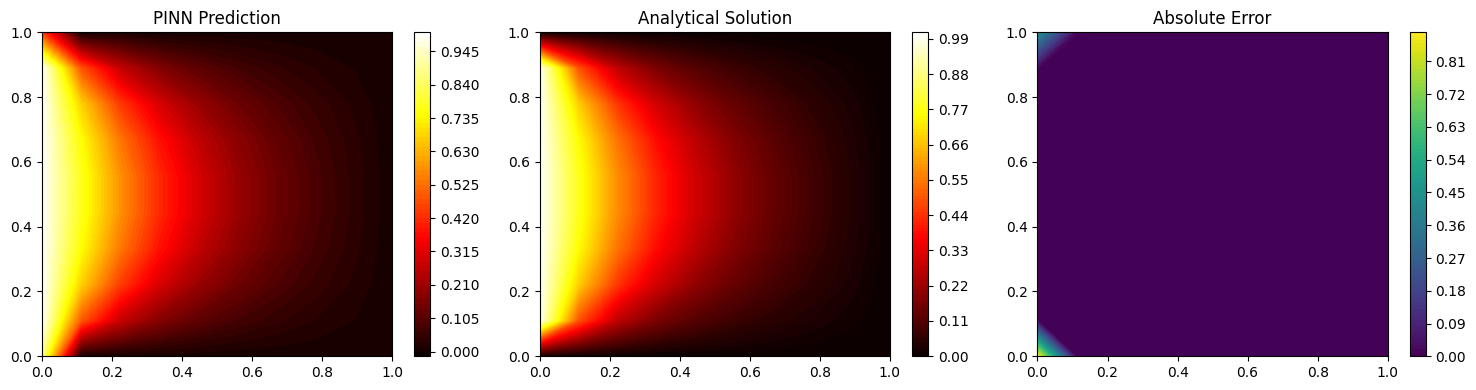

In [ ]:
# Domain
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Analytical solution with T=1 on x=0, and T=0 on all the other edges
def analytical_solution(X, Y, terms=100):
  T = np.zeros_like(X)
  for n in range(1, 2 * terms, 2):  # odd terms only
    lambda_n = n * np.pi
    coef = 4 / (np.pi * n)
    term = coef * np.sinh(lambda_n * (1 - X)) * np.sin(lambda_n * Y) / np.sinh(lambda_n)
    T += term
  return T

# Compute true solution
T_true = analytical_solution(X, Y)

# Compute predicted solution using the trained PINN model
model.eval()
with torch.no_grad():
  xy_grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
  T_pred = model(xy_grid)
  T_pred = T_pred.numpy().reshape(10, 10)

# Compute absolute error
error = np.abs(T_pred - T_true)

# Plotting
plt.figure(figsize=(15, 4))

# PINN Prediction
plt.subplot(1, 3, 1)
plt.contourf(X, Y, T_pred, levels=100, cmap='hot')
plt.colorbar()
plt.title('PINN Prediction')

# Analytical Solution
plt.subplot(1, 3, 2)
plt.contourf(X, Y, T_true, levels=100, cmap='hot')
plt.colorbar()
plt.title('Analytical Solution')

# Absolute Error
plt.subplot(1, 3, 3)
plt.contourf(X, Y, error, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()


# Questions
- why the loss is a weighted summation of PDE and BC loss terms?
- how the weighted losses are affecting the training?
- what does it meand to consider more weight to one loss term?
- how to stabalize the training solely based on the governing equation and BCs?
- how can the model be generalized to predict solutions out of the specified domain or with different parameter values of the physical constraints?
- what issues may raise by taking higher-order derivatives to address the loss of a high-order PDE?